In [1]:
import rasterio
import numpy as np
from rasterio import features
from affine import Affine
from shapely.geometry import shape, box, Polygon, Point, MultiPolygon
from shapely import affinity

from matplotlib import pyplot as plt
import descartes

In [22]:
def mean_image_rescale(img, scale):
    h, w = int(img.shape[0]/scale), int(img.shape[1]/scale)
    out_img = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            out_img[i,j] = np.mean(img[int(i*scale):int((i+1)*scale), int(j*scale):int((j+1)*scale)])
    return out_img

def pct_rasterize_via_upsampling(geo, h, w, scale=10.0):
    up_h, up_w = int(h*scale), int(w*scale)
    center     = np.mean(geo.envelope.exterior, axis=0)
    geo        = affinity.scale(geo, xfact=scale, yfact=scale, origin='center')
    #geo        = affinity.scale(geo, xfact=scale, yfact=scale, origin='centroid')
    geo        = affinity.translate(geo, xoff=center[0]*scale, yoff=center[1]*scale)
    raster     = features.rasterize(geo, out_shape=(up_h, up_w), fill=0, all_touched=False)
    out_raster = mean_image_rescale(raster, scale)
    return out_raster

GEOM Area:  58.585000000000015


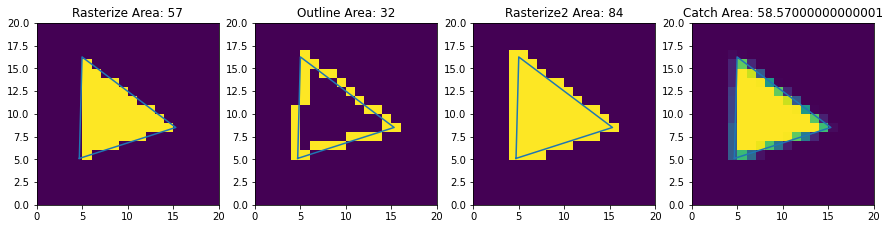

In [36]:
geom = Polygon([[4.7,5.1],[15.3,8.5],[5,16.25]])
h,w = 20,20
scale = 10

mask       = features.rasterize([geom], out_shape=(h,w), fill=0, all_touched=False)
out_mask   = features.rasterize([geom], out_shape=(h,w), fill=0, all_touched=True)
in_mask    = features.rasterize([geom.exterior], out_shape=(h,w), fill=0, all_touched=False)
catch_mask = pct_rasterize_via_upsampling(MultiPolygon([geom]), h,w, scale=scale)

print('GEOM Area: ', geom.area)

fig, axes = plt.subplots(1,4, figsize=(15,30))
axes[0].set_title('Rasterize Area: '+str(np.sum(mask)))
axes[0].imshow(mask,       extent=(0,h,0,w), origin='lower')
axes[1].set_title('Outline Area: '+str(np.sum(in_mask)))
axes[1].imshow(in_mask,    extent=(0,h,0,w), origin='lower')
axes[2].set_title('Rasterize2 Area: '+str(np.sum(out_mask)))
axes[2].imshow(out_mask,   extent=(0,h,0,w), origin='lower')
axes[3].set_title('Catch Area: '+str(np.sum(catch_mask)))
axes[3].imshow(catch_mask, extent=(0,h,0,w), origin='lower')
xs, ys = geom.exterior.xy 
for i in range(4): axes[i].plot(xs, ys)